In [1]:
import warnings
import intake
import xarray as xr
import proplot as plot
import pandas as pd
import cftime
import GPy
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

# Fitting a Gaussian process to UKESM climate data

Table of contents:
- [1. Preparing the data](#1.-Preparing-the-data)
    - [1.1. Fetching the data](#1.1.-Fetching-the-data)
    - [1.2. Exploring the data](#1.2.-Exploring-the-data)
    - [1.3. Plotting the data](#1.3.-Plotting-the-data)
    - [1.4. Splitting the data into training, validation, and test sets](#1.4.-Splitting-the-data-into-training-validation-test-sets)
- [2. Fitting a GP](#2.-Fitting-a-GP)

## 1. Preparing the data
### 1.1. Fetching the data

UKESM1.0 is part of the 6th iteration of CMIP, the Coupled Model Intercomparison Project. The data that resulted from its runs is publicly available from the CMIP6 archive which can be accessed manually [here](https://esgf-index1.ceda.ac.uk/search/cmip6-ceda/). Below, we use the library `intake-esm` to load and process the data for our model from the CMIP6 catalogue.

In [2]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
catalogue = intake.open_esm_datastore(url)

This dataframe contains a list of all available experiments, indexed by a number of [meta-variables](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit) like the `institution_id`, `source_id` etc. These experiments are different types of runs for each model, for different variables. For example, we could be looking at the precipitation output of a 1% CO2 simulation, or at the simulation of historical values of sea level pressure. More information about the variables that are available can be found [here](https://pcmdi.llnl.gov/CMIP6/Guide/dataUsers.html).

In [3]:
catalogue.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Among these entries, we can search for the ones we're interested in: the values of precipitation in a [historical experiment](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=historical) from the Met Office Hadley Centre (MOHC).

In [4]:
models = catalogue.search(experiment_id="historical",
                          variable_id="pr",
                          institution_id="MOHC",
                          member_id="r1i1p1f2")

models

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,2
variable_id,1
grid_label,1
zstore,2
dcpp_init_year,0


In [5]:
datasets = models.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In this address: `activity_id.institution_id.source_id.experiment_id.table_id.grid_label`, 
- `source_id` is the model
- `experiment_id` is the experiment
- `table_id` is the temporal frequency

In [6]:
datasets.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.day.gn'])

Above, the two experiments differ in the time resolution of the data. `day` offers daily data, `Amon` monthly.

In [7]:
ds = datasets["CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn"]
ds

<xarray.Dataset>
Dimensions:    (lat: 144, bnds: 2, lon: 192, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 144, 192), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   144000.0
    cmor_version:            3.4.0
    ...                      ...
    variant_label:           r1i1p1f2
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/f35b8979-27a3-4e33-9708-43fb5001fb9...
    version_id:              v20190406
    intake_esm_varname:      ['pr']
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn

In [8]:
df = ds.to_dataframe()

### 1.2. Exploring the data

In this data, there is one entry for each month's precipitation, for each combination of latitude and longitude.

The latitude varies from -89.375 to 89.375 in 1.25 degree increments (143 values in total).

The longitude varies from 0.9375 to 359.0625 in 1.875 degree increments (192 values times 2 bands, 384 in total).

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109486080 entries, (-89.375, 0, 0.9375, 'r1i1p1f2', cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True)) to (89.375, 1, 359.0625, 'r1i1p1f2', cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True))
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   lat_bnds   float64
 1   lon_bnds   float64
 2   pr         float32
 3   time_bnds  object 
dtypes: float32(1), float64(2), object(1)
memory usage: 3.7+ GB


In other words, for each degree of latitude, we have 760,320 measurements = 1980 precipitation measurements × 384 values of longitude.

In [10]:
uk_latitude, uk_longitude = (50, 60), (2, 353)
df = df.loc[(df.index.get_level_values("bnds")==0)]

uk_regional_data = df.loc[((df.index.get_level_values("lat") >= uk_latitude[0]) & (df.index.get_level_values("lat") <= uk_latitude[1])) & # Latitude between 50-60.
                           (((df.index.get_level_values("lon") >= 0) & (df.index.get_level_values("lon") <= uk_longitude[0])) | # Longitude between 0 and 2 degrees or
                             ((df.index.get_level_values("lon") >= uk_longitude[1]) & (df.index.get_level_values("lon") <= 360)))] # between 353 and 360.

In [11]:
uk_regional_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 79200 entries, (50.625, 0, 0.9375, 'r1i1p1f2', cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True)) to (59.375, 0, 359.0625, 'r1i1p1f2', cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True))
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat_bnds   79200 non-null  float64
 1   lon_bnds   79200 non-null  float64
 2   pr         79200 non-null  float32
 3   time_bnds  79200 non-null  object 
dtypes: float32(1), float64(2), object(1)
memory usage: 2.8+ MB


In [12]:
uk_train = uk_regional_data.loc[(uk_regional_data.index.get_level_values("time") < cftime.Datetime360Day(1950, 1, 16, 0, 0, 0, 0, has_year_zero=True))]
uk_test = uk_regional_data.loc[(uk_regional_data.index.get_level_values("time") >= cftime.Datetime360Day(1950, 1, 16, 0, 0, 0, 0, has_year_zero=True))]

In [13]:
x_train, x_test = [], []
for lat, _, lon, _, time in uk_train.index:
    x_train.append([lat, lon, cftime.date2num(time, "months since 1850-01-16")])
    
for lat, _, lon, _, time in uk_test.index:
    x_test.append([lat, lon, cftime.date2num(time, "months since 1850-01-16")])

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = uk_train["pr"].to_numpy()
y_test = uk_test["pr"].to_numpy()

x_train[:5], y_train[:5], x_test[:5], y_test[:5]

(array([[50.625 ,  0.9375,  0.    ],
        [50.625 ,  0.9375,  1.    ],
        [50.625 ,  0.9375,  2.    ],
        [50.625 ,  0.9375,  3.    ],
        [50.625 ,  0.9375,  4.    ]]),
 array([3.0822695e-05, 2.0160012e-05, 2.5820647e-05, 5.5461501e-06,
        1.6837410e-05], dtype=float32),
 array([[5.0625e+01, 9.3750e-01, 1.2000e+03],
        [5.0625e+01, 9.3750e-01, 1.2010e+03],
        [5.0625e+01, 9.3750e-01, 1.2020e+03],
        [5.0625e+01, 9.3750e-01, 1.2030e+03],
        [5.0625e+01, 9.3750e-01, 1.2040e+03]]),
 array([2.3812347e-05, 1.2404875e-05, 3.7110558e-06, 1.4123646e-05,
        5.2484465e-06], dtype=float32))

In [15]:
x_train.shape

(48000, 3)

In [42]:
x_train_small = x_train[(x_train[:, 2] > 1079)]
y_train_small = y_train[-x_train_small.shape[0]:]

x_test_small = x_test[(x_test[:, 2] < 1220)]
y_test_small = y_test[-x_test_small.shape[0]:]

x_train_small.shape, y_train_small.shape, x_test_small.shape, y_test_small.shape

((4800, 3), (4800,), (800, 3), (800,))

In [45]:
x_train_small.reshape(-1, 1).shape
y_train_small.reshape(-1, 1).shape

(4800, 1)

## 2. Fitting a GP 

In [49]:
kernel = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
model = GPy.models.GPRegression(x_train_small, y_train_small.reshape(-1, 1), kernel=kernel, normalizer=False, noise_var=0.05)

Below we display the model (with all its associated parameters as they have been trained) and then plot the GP fit to the training data.

In [47]:
display(model)
model.plot(figsize=(5, 5), dpi=100, xlabel="time", ylabel="precipitation")

GP_regression.,value,constraints,priors
sum.rbf.variance,3.5,+ve,
sum.rbf.lengthscale,2.6,+ve,
sum.periodic_Matern32.variance,3.5,+ve,
sum.periodic_Matern32.lengthscale,10.0,+ve,
sum.periodic_Matern32.period,6.283185307179586,+ve,
Gaussian_noise.variance,0.05,+ve,


TypeError: calculated free_dims [0 1 2] from visible_dims None and fixed_dims [] is neither 1D nor 2D

Finally, let's see how the fitted model predicts precipitation data on the 14 data points in the test set.

In [56]:
y_mean, y_std = model.predict(x_test)

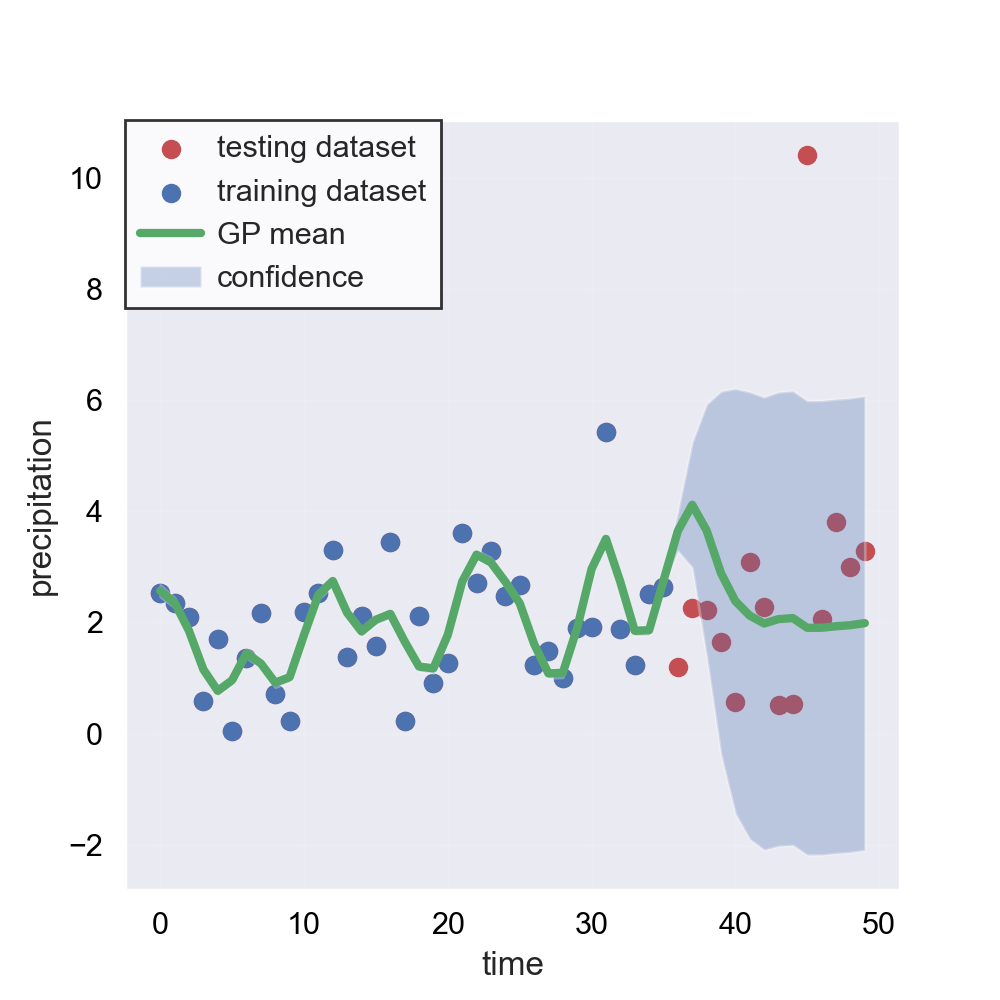

In [59]:
plt.figure(figsize=(5, 5), dpi=100)
sns.set()
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(Xtest, Ytest, lw=1, color="r", label="testing dataset")
plt.scatter(Xtrain, Ytrain, lw=1, color="b", label="training dataset")
plt.plot(Xtest, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(Xtest, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()